# 1. Description of the problem and importing libraries

In recent years, bike sharing services are gradually becoming an integral part of city life. More and more people realise the advantages of being able to avoid traffic jams while getting some free cardio training. For the smooth functioning of such a system, it is imperative that the docking stations contain the appropriate number of bikes for the public to use: not too many (for cost efficiency), but also not too few (for customer satisfaction).

In this example, we will implement machine learning to predict the number of rented bikes at a given hour on a given day of the year. 

As a first step, we import the libraries for data exploration and for constructing our predictive model. Since we aim to predict the number of the rented bikes, we have a regression problem on our hands. Also, as we will see below, most of the important features (for example **year**, **month**, **weather** **workingday**, **holiday**, etc) assume only a few discreet values, so a decision tree based model, like the *Random Forest Regressor*, is a convenient and sensible choice. Using several, decorrelated decision trees, it will also help to avoid overfitting the data set. In order to perform cross-validation on the ensemble, we import *GridSearchCV*.

In [21]:
# Linear algebra, data manipulation and data visualization

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_context('talk')
#sns.set_style('whitegrid')
%matplotlib inline

# Library for dates and times
import datetime

# Modelling

# Creating polynomial features and scaling the feature matrix values to [-1, 1]
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.preprocessing import MaxAbsScaler

# Polynomial regression classifier
# from sklearn.linear_model import Ridge

# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# Pipeline for chaining transformers and classifier
# from sklearn.pipeline import make_pipeline

# We'll need to split the data set into train and test sets, as well as
# scan along several parameters and select the best model by cross-validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


# 2. Loading the data set and transformations

Let us read in the data set and take a first look at the features.

In [3]:
train_df = pd.read_csv('data.csv', header=0)

In [4]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


* **datetime** gives the year, month, day, hour, minute, second of the obsevation
* **season** gives the season: *1: spring*, *2: summer*, *3: autumn*, *4: winter*
* **holiday** shows if the day was a school holiday (not necessarily a weekend!)
* **workingday** tells if the day was a work day
* **weather** indicates if it was *1: clear or cloudy*, *2: misty*, *3: light rain or snow*, *4: Heavy rains or snow*
* **temp** shows the actual temperature
* **atemp** gives the "feels like" temperature 
* **humidity** 
* **windspeed** tells the wind velocity
* **casual** is the amount of casual rents
* **registered** shows the amount of bikes taken  by subscription
* **count** is the sum of **casual** and **registered**

The variable we aim to predict is **count**. However, the total number of rented bikes is the sum of two other features: **casual** and **registered**. It might be worthwhile to examine the trends of these two features separately because the behaviour of casual and registered users might differ significantly!  

Let's take a quick look at the completness of the dataset, whether there are any missing or invalid values.

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


We are in luck, there doesn't seem to be any missing values. For an easier data handling, it is worth to transform the **datetime** column into columns of **year**, **month**, **day** and **hour**. We can define a function for this that uses the *datetime* package.

In [6]:
# Extracting date and time: we create Year, Month, Day, Hour features

def datetime_breakdown(datetime_item):
    datetime_obj = datetime.datetime.strptime(datetime_item, '%Y-%m-%d %H:%M:%S')
    
    year = datetime_obj.year
    month = datetime_obj.month
    day = datetime_obj.day
    hour = datetime_obj.hour
    
    return (year, month, day, hour)

# Create corresponding columns

train_df['datetime_extr'] = train_df['datetime'].map(datetime_breakdown)
date_parts = ['year', 'month', 'day', 'hour']

for index in range(4):
    
    time_type = date_parts[index]
    train_df[time_type] = train_df['datetime_extr'].map(lambda item: item[index])

# Drop the obsolete columns
train_df.drop('datetime', inplace=True, axis=1)
train_df.drop('datetime_extr', inplace=True, axis=1)

# For a nicer layout, we rearrange the columns, putting the date and time in the start as it was originally
oldcols = train_df.columns.tolist()
newcols = oldcols[11:15] + oldcols[0:11]

train_df = train_df[newcols]


In [7]:
train_df.head()

,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011,1,1,0,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011,1,1,1,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011,1,1,2,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011,1,1,3,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011,1,1,4,1,0,0,1,9.84,14.395,75,0.0,0,1,1


Our data is now in a format we can handle more easily. Let's see which parameters are relevant for predicting the rent count, and which ones can be thrown away.

# 2. Data exploration

Our objective is to construct a model that predicts the parameter **count**, i.e., the number of bikes actually being hired. It is, however, apparent that **count** is the sum of **registered** and **casual** hires. It is very probable that **registered** and ** casual** are influenced more or less differently by the different features. For a registered rent, one would expect that people are less influenced by the momentary temperature and weather conditions, they rather plan according to the time of year. A casual rent, on the other hand, is usually something more spontaneous, influenced by the weather conditions on a given day, as well as that day being a workday or a holiday.

So, let us not look directly at **count** but let us examine **registered** and **casual** separately, and, if there is sufficient reason for it, make two separate predictive models for them, and take the final prediction for **count** as the sum of the output of these two models.

We examine the influence of a particular feature by averaging the value of a target feature over *all* the rest of the features. In this way, the influence of the other parameters is "smudged" and we only retain the trend set by the feature we are interested in. For example, let us say we want to understand the contribution of **month** to the **registered** counts. In order to do this, we divide the total data set into subsets, indexed by the values of **month**. This means, that a given subset contains observations that have been taken in the same month. Subsequently, we take the average value of **registered** in each subset and as a result, we are left with a quantity depending only on the variation of the **month** feature.

In [8]:
def grouped_mean_DF(df, grouping_feature, target_name, hue_name, hue_features):
    
    # This function creates a DataFrame that simplifies the visualization of the effect that  a single feature 
    # ('grouping feature') has upon the target variable(s). 'target name' is the header of the column containing all target
    # variable values, 'hue name' is the column header containing the 'hue feature's which indicate the types of the different
    # target variable values.
    
    # With this, it's easy to show and compare the effect of 'grouping_feature' on the different types of target variables
    # in the same plot.
    
    # The construction takes two steps. 
    # First, we group the original data set according to 'grouping_feature', and then we average them.
    
    grouping_feature_values = list(set(df[grouping_feature]))
    grouping_feature_values.sort()
    grouped_mean = df.groupby(grouping_feature).mean()
    
    # Next, we construct the DataFrame that will contain the averaged target feature values, indexed by the target feature types
    # (i.e., the 'hue_features')
    grouped_mean_df = pd.DataFrame()
    
    grouping_list=[]
    target_list = []
    hue_list=[]
    
    for item in hue_features:
        grouping_list += grouping_feature_values
        target_list += list(grouped_mean[item])
        hue_list += len(grouping_feature_values) * [item]
    
    grouped_mean_df[grouping_feature] = grouping_list
    grouped_mean_df[target_name] = target_list
    grouped_mean_df[hue_name] = hue_list
    
    return grouped_mean_df

# As an example, here is the two kinds of averaged hire counts, projected on the years
grouped_by_year = grouped_mean_DF(train_df, 'year', 'counts', 'count_type', ['registered', 'casual'])
grouped_by_year.head()

,year,counts,count_type
0,2011,115.485430,registered
1,2012,195.310944,registered
2,2011,28.737920,casual
3,2012,43.250000,casual


## 2.1. Year

We have data for years 2011 and 2012 which provides only two data points. Still, let us look at the average hire count for **registered** and **casual**.

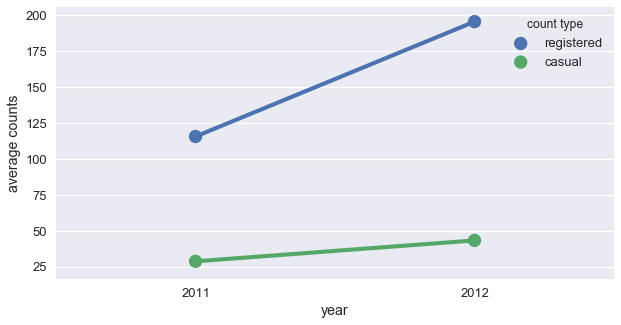

In [9]:
by_year_df = grouped_mean_DF(train_df, 'year', 'average counts', 'count type', ['registered', 'casual'])

fig, ax1 = plt.subplots(1, 1, figsize=(10,5))
sns.pointplot(x='year', y='average counts', data=by_year_df, hue='count type')

ax1.set_ylabel('average counts')

plt.savefig('data_year.pdf')

Apparently, the bike service has almost doubled its popularity from 2011 to 2012! Both for **casual** and **registered** customer behaviour, the **year** parameter seems to be a meaningful one.

## 2.2. Month

For a person who plans their bike hires in advance, it must be important what time of year it is. Let's see how significant **month** is for the registered, as well as for casual users. 

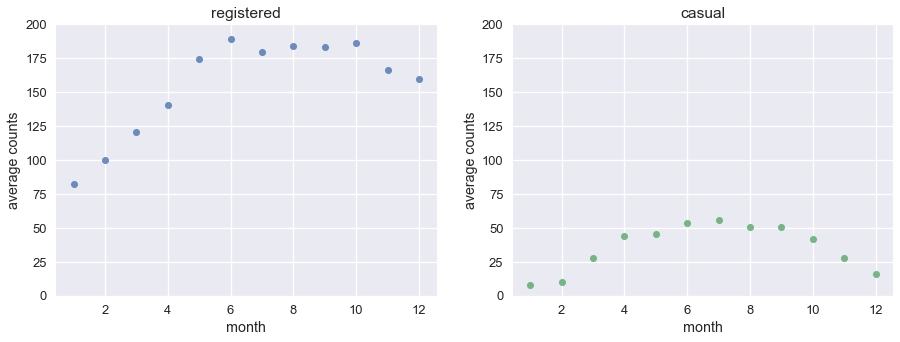

In [10]:
by_month_df = grouped_mean_DF(train_df, 'month', 'average counts', 'count type', ['registered', 'casual'])

by_temp_month_df = grouped_mean_DF(train_df, 'month', 'average temp', 'temp type', ['temp'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.regplot(x='month', y='average counts',  data=by_month_df[by_month_df['count type'] == 'registered'],
            fit_reg=False, scatter_kws={'s':50}, ax=ax1)
sns.regplot(x='month', y='average counts',  data=by_month_df[by_month_df['count type'] == 'casual'],
            fit_reg=False, scatter_kws={'s':50}, ax=ax2)


ax1.set_title('registered')
ax1.set_xticks(list(range(2, 13, 2)))
ax1.set_ylim(0, 200)

ax2.set_title('casual')
ax2.set_xticks(list(range(2, 13, 2)))
ax2.set_ylim(0,200)

plt.savefig('data_month.pdf')

It seems that **month** is a relevant feature for both types of count. However, we can see some difference in their behaviour: the average **registered** count always stays above 75 and at the end of the year it only falls back moderately compared to its peak value. However, **casual** seems to reflect more the expected weather conditions during the year: in the winter months it is close to zero, and as it gets warmer, it increases. 

Thus, **month** seems to be a *relevant* feature for *both* types of counts.

## 2.3. Day

Let's take a look at the average hire counts as functions of **day**. 

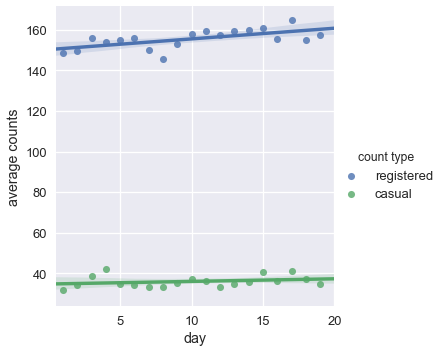

In [11]:
by_day_df = grouped_mean_DF(train_df, 'day', 'average counts', 'count type', ['registered', 'casual'])

sns.lmplot(x='day', y='average counts', hue='count type', data=by_day_df, fit_reg=True, scatter_kws={'s':50})
plt.xlim([0.5, 20])

plt.savefig('data_day.pdf')

As opposed to **month**, it seems that there is not much going on here. The behaviour for both **registered** and **casual** is pretty flat, if we fit a linear function on them, for **casual** we get an almost 0 slope, and for **registered** we observe a slight increase towards to second half of the month. 

Since there is no significant variation here, **day** *does not seem to be an important feature* for either **registered** or **casual**. 

## 2.4. Hour

What about the time of day? We expect that, since humans have schedules and a certain daily rhythm, the variation of hours plays an important role in the expected values of hired bikes.

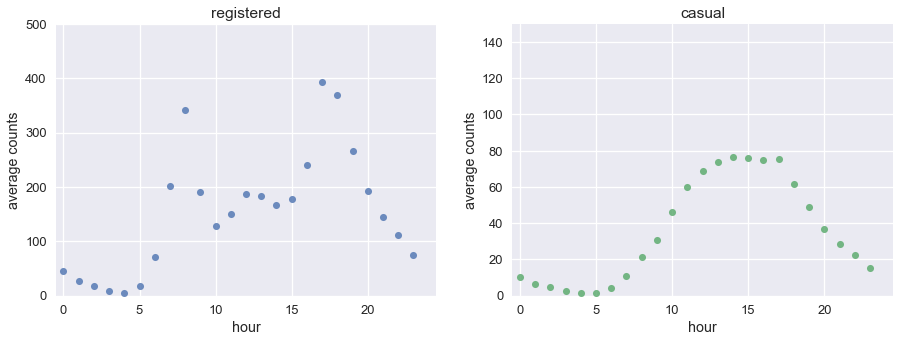

In [12]:
by_hour_df = grouped_mean_DF(train_df, 'hour', 'average counts', 'count type', ['registered', 'casual'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.regplot(x='hour', y='average counts', data=by_hour_df[by_hour_df['count type']=='registered'], fit_reg=False, scatter_kws={'s':50}, ax=ax1)
sns.regplot(x='hour', y='average counts', data=by_hour_df[by_hour_df['count type']=='casual'], fit_reg=False, scatter_kws={'s':50}, ax=ax2)

ax1.set_title('registered')
ax1.set_xlim([-0.5, 24.5])
ax1.set_ylim([0, 500])

ax2.set_title('casual')
ax2.set_xlim([-0.5, 24.5])
ax2.set_ylim([0, 150])

plt.savefig('data_hour.pdf')

And indeed it does! One sees a substantial variation in the average count during the 24 hours of a day. It is different, though, for the two types of hire. For **registered**, we observe two peaks during the day: one in the morning around 7:00 and another in the afternoon around 17:00. We can surmise that registered clients take out bikes either in the morning before work, or in the afternoon after work. For **casual**, we get a single, broad peak that reaches from morning till afternoon. 

It is apparent that **hour** is an important feature for both **registered** and **casual**.

## 2.5. Season

Common sense suggests that the feature **season** should not bring in any new information compared to **month**, since knowing the given month, we automatically know the season.

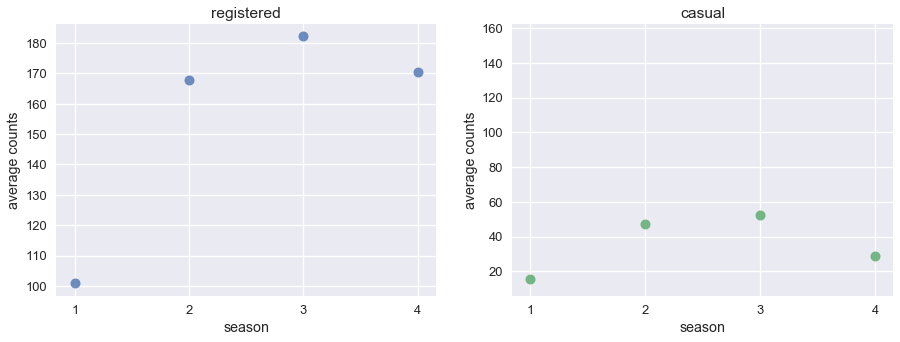

In [13]:
by_season_df = grouped_mean_DF(train_df, 'season', 'average counts', 'count type', ['registered', 'casual'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.regplot(x='season', y='average counts', data=by_season_df[by_season_df['count type']=='registered'],
            fit_reg=False, scatter_kws={'s':100}, ax=ax1)
sns.regplot(x='season', y='average counts', data=by_season_df[by_season_df['count type']=='casual'], 
            fit_reg=False, scatter_kws={'s':100}, ax=ax2)

ax1.set_title('registered')
ax2.set_title('casual')

ax1.set_xticks([1, 2, 3, 4])
ax2.set_xticks([1, 2, 3, 4])

plt.savefig('data_season.pdf')

Indeed, comparing these graphs with those in **2.2.**, we see a practically identical behaviour. Including **season** in our model will not give additional information compared to what we have from **month**. For that reason, we can *discard* **season** from the list of significant parameters.

## 2.6. Holiday/Workday

**day** as a number did not have a strong influence on the hire counts, however, it might make a difference if a day is **holiday** or a **workingday**.

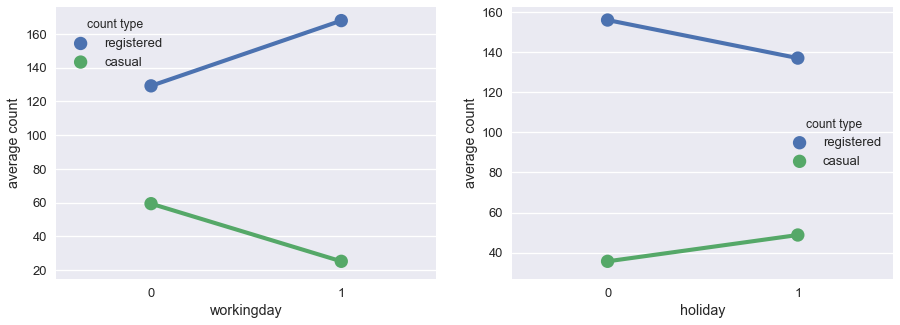

In [14]:
by_holiday_df = grouped_mean_DF(train_df, 'holiday', 'average count', 'count type', ['registered', 'casual'])
by_workingday_df = grouped_mean_DF(train_df, 'workingday', 'average count', 'count type', ['registered', 'casual'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 5) )

sns.pointplot(x='workingday', y='average count', hue = 'count type', data=by_workingday_df, ax=ax1)
sns.pointplot(x='holiday', y='average count', hue = 'count type', data=by_holiday_df, ax=ax2)

ax1.set_ylabel('average count')
ax2.set_ylabel('average count')

plt.savefig('data_holiday_workday.pdf')

As one would expect, it is more likely that it is **registered** clients who use bikes on workdays. **casual** customers, who rather use a bike for recreational activities, will more likely come in during weekends and holidays.

Both **workingday** and **holiday** seem to be significant parameters: we include them in the model.

## 2.7. Weather 
### (*1: clear or cloudy*, *2: misty*, *3: light rain or snow*, *4: Heavy rain or snow*)

How does **weather** affect the two types of hires? One would expect a strong dependence of **casual** hires on weather since good weather is a potential motivation for people to decide for taking out a bike spontaneously. **registered** should at least have a much weaker dependence on **weather**, if any at all.

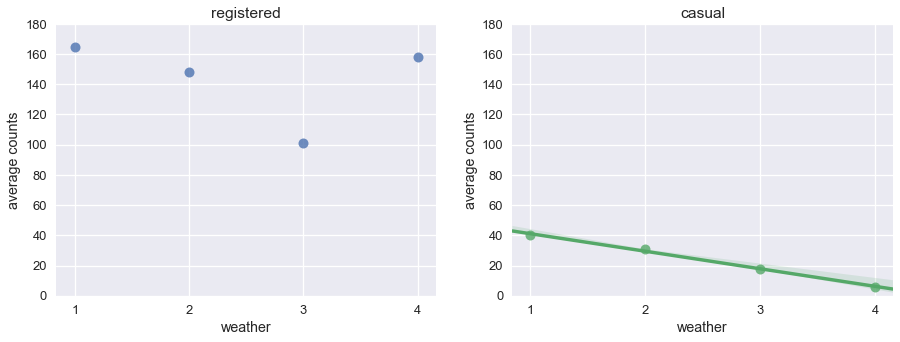

In [15]:
by_weather_df = grouped_mean_DF(train_df, 'weather', 'average counts', 'count type', ['registered', 'casual'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.regplot(x='weather', y='average counts', data=by_weather_df[by_weather_df['count type']=='registered'],
            fit_reg=False, scatter_kws={'s':100}, ax=ax1)
sns.regplot(x='weather', y='average counts', data=by_weather_df[by_weather_df['count type']=='casual'], 
            fit_reg=True, scatter_kws={'s':100}, ax=ax2)

ax1.set_title('registered')
ax2.set_title('casual')

ax1.set_xticks([1, 2, 3, 4])
ax2.set_xticks([1, 2, 3, 4])

ax1.set_ylim([0, 180])
ax2.set_ylim([0,180])

plt.savefig('data_weather.pdf')

The difference in behaviour is apparent. **registered** has practically no dependence on the momentary weather conditions: we have about the same average value for *clear or cloudy* and *heavy rain/snow*, and a lower value for *light rain/snow* than for *heavy rain/snow*. Therefore, we can *discard* **weather** from the list of significant parameters for **registered**.

However, in case of **casual**, we see a steady decline in the number of hires as the weather gets worse and worse - it is practically a linear relationship. **weather** is an *important parameter* for predicting **casual**.

## 2.8. Temp, Humidity and Windspeed combined: Atemp

Since **atemp** (apparent temperature) is calculated from measured **temperature**, **humidity** and **windspeed**, we can reduce the number of features without much loss of information if we keep **atemp** and discard the other three. 

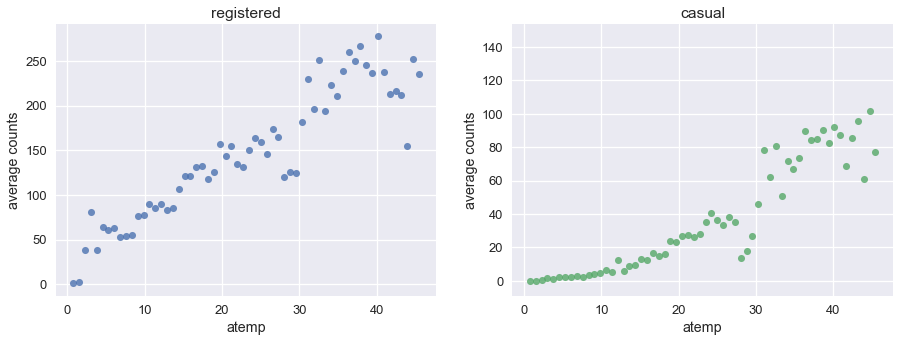

In [16]:
by_atemp_df = grouped_mean_DF(train_df, 'atemp', 'average counts', 'count type', ['registered', 'casual'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.regplot(x='atemp', y='average counts', data=by_atemp_df[by_atemp_df['count type']=='registered'],
            fit_reg=False, scatter_kws={'s':50}, ax=ax1)
sns.regplot(x='atemp', y='average counts', data=by_atemp_df[by_atemp_df['count type']=='casual'], 
            fit_reg=False, scatter_kws={'s':50}, ax=ax2)

ax1.set_title('registered')
ax2.set_title('casual')

plt.savefig('data_atemp.pdf')

We can see a clear dependence on the momentary apparent temperature both for **registered** and **casual**. For the latter, it makes complete sense, since momentary weather conditions have a strong effect on a decision to spontaneously hire a bike. But what about **registered**? Well, we have seen that there was very little correlation between momentary **weather** and **registered**. But we know that there is a strong causal connection between **month** and **registered**. Since there are warmer and colder months in the year, the correlation between **registered** and **atemp** is most likely due to the correlation between **month** and **temp**. Therefore, keeping **atemp** as a feature for predicting **registered** would not bring us a significant amount of information.

Thus, we will *discard* **atemp** from the predictors for **registered**, but *keep* it for the model for **casual**.

## 2.9. Significant features

All these considered, **registered** and **casual** depend strongly on the following features:

### Registered:

* year
* month
* hour
* holiday
* workingday

### Casual:

* year
* month
* hour
* holiday
* workingday
* weather
* atemp

# 3. Model construction

Based on what we have seen above, we can choose at least two ways to proceed. We can construct two separate models predicting **casual** and **registered**, and take the sum of the separate predictions as a prognose for **count**. Alternately, we can construct a single model that predicts **count** in one go. We will do both, and choose the method giving the better result. 

## 3.1. Regression with Random Forests

We will use a Random Forest Regressor to predict **count**, since most of our features (the only exception being **atemp**) are variables that assume a few discreet values, instead of being continuous. For the cross-validation procedure we make a parameter grid where the maximal amount of features for a split in a tree, the maximal depth (leaf number) of the individual trees and the number of the trees in the forest are varied to find the best model.

In [23]:
forest_regressor = RandomForestRegressor()

param_grid = {
    'max_features' :['auto', 'sqrt'],
    'max_depth' : [14, 15, 16],
    'n_estimators' : list(range(250, 350, 10))
}

grid_search = GridSearchCV(forest_regressor, param_grid, cv=5)

Great, we have prepared everything! Let's unleash the regressor on our data sets. 

## 3.2. Separate predictions for **casual** and **registered**

We create the arrays containing the predictors and the target variables belonging to **casual** and **registered** separately. Subsequently, we split both data sets into train and test sets.

In [28]:
data_casual = train_df[['year', 'month', 'hour', 'holiday', 'workingday', 'weather', 'atemp']]
data_registered = train_df[['year', 'month', 'hour', 'holiday', 'workingday']]

target_casual = train_df['casual']
target_registered = train_df['registered']

X_train_c, X_test_c, Y_train_c, Y_test_c = train_test_split(data_casual, target_casual, test_size=0.4, random_state=0)
X_train_r, X_test_r, Y_train_r, Y_test_r = train_test_split(data_registered, target_registered, test_size=0.4, random_state=0)

For **casual**:

We let the model train, based on the train data.

In [29]:
grid_search.fit(X_train_c, Y_train_c)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': ['auto', 'sqrt'], 'max_depth': [14, 15, 16], 'n_estimators': [250, 260, 270, 280, 290, 300, 310, 320, 330, 340]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Let's take a look at the parameters associated with the best score, and the score itself.

In [30]:
grid_search.best_params_

{'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 330}

In [31]:
grid_search.best_score_

0.89403653293503371

If we apply the cross-validated model on the test set, we get

In [32]:
grid_search.score(X_test_c, Y_test_c)

0.88881465721882058

For **registered**: we follow the same steps.

In [33]:
grid_search.fit(X_train_r, Y_train_r)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': ['auto', 'sqrt'], 'max_depth': [14, 15, 16], 'n_estimators': [250, 260, 270, 280, 290, 300, 310, 320, 330, 340]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [34]:
grid_search.best_params_

{'max_depth': 14, 'max_features': 'sqrt', 'n_estimators': 250}

In [35]:
grid_search.best_score_

0.89661594210806794

In [36]:
grid_search.score(X_test_r, Y_test_r)

0.89042940651018465

Both models give an **R^2 score of about 0.89** when applied to the test set. 

## 3.3. Predicting count directly

According to the observed trends in the data sets, the significant parameters to predict **count** are

**year**, **month**, **hour**, **holiday**, **workingday**, **weather**, **atemp**.

We can now create the arrays containing the predictors and the target variables. Subsequently, we split the total data set into train and test sets.

In [37]:
data = train_df[['year', 'month', 'hour', 'holiday', 'workingday', 'weather', 'atemp']]
target = train_df['count']

X_train, X_test, Y_train, Y_test = train_test_split(data, target, test_size=0.4, random_state=0)


In [38]:
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': ['auto', 'sqrt'], 'max_depth': [14, 15, 16], 'n_estimators': [250, 260, 270, 280, 290, 300, 310, 320, 330, 340]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The parameter set and the score belonging to the best configuration are

In [39]:
grid_search.best_params_

{'max_depth': 14, 'max_features': 'auto', 'n_estimators': 330}

In [40]:
grid_search.best_score_

0.93162292334138674

Now that we have established the model, let us test it on the test set. 

In [41]:
grid_search.score(X_test, Y_test)

0.92559873386835756

The **R^2 score** given by this model on the test set is about **0.93**, which is significantly better than the prediction score of the former approach!

## 3.4. Outlook to improve the model 

Besides choosing some other model that could produce better scores with the same features, one could do some feature engineering, and construct new variables based on the existing relevant ones, for example by multiplying them (**hour** x **month**, **hour** x **atemp**, **atemp** x **weather**). Another approach would be the creation of **dummy variables** which results in  a multitude of features assuming values of 1 or 0, and can potentially improve the results of the random forest procedure.